# Authors of the code are Sudeep Ghosh and Siddhant Rathi :)


In [37]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import math

In [40]:
#https://qiskit.org/textbook/ch-applications/vqe-molecules.html
#"Up to a global phase, any possible single qubit transformation may be implemented by appropriately setting these parameters"

# The rationale behind this program is to calculate the parameters theta. lambda, and phi 
# from the given values of the matrix elements in the normalized unitary matrix A

# functions like limDivision, etc. are used to overcome implementational issues

# Note - This is not a robust implementation, as the present Qiskit implementation of the u3 gate 
# does not accept complex angle values. This would mean that the first element of the matrix A MUST be real (cos(theta/2))  


import numpy as np
import cmath
from qiskit import *

def limDivision(x, y):
    if(y != 0):
        return x/y
    else:
        return 0

def determinant(A):
    return abs(A[0][0]*A[1][1] - A[0][1]*A[1][0])
    
def mapAtoU3(A):
    mod = determinant(A)
    a11 = A[0][0]/mod
    a12 = A[0][1]/mod
    a21 = A[1][0]/mod
    a22 = A[1][1]/mod
    
    thetaA = 2*cmath.acos(a11)
    
    if abs(cmath.sin(thetaA/2)) <= 10e-4:
        phiA = 0
        lambdaA = -1j*cmath.log(limDivision(a22, cmath.cos(thetaA/2)))
    else:    
        phiA = -1j*cmath.log(limDivision(a21, cmath.sin(thetaA/2)))
        lambdaA = -1j*cmath.log(limDivision(-a12, cmath.sin(thetaA/2)))
    
    paramsA = [thetaA, phiA, lambdaA]
        
    if((paramsA[0].imag)*(paramsA[1].imag)*(paramsA[2].imag) <= 10e-4):
        return paramsA
    else:
        print('Invalid Matrix - Check Note')
        
def lambdaFromK(k):
    return np.pi/pow(2, k-1)

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The QuantumCircuit.cu3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cu method instead, where cu3(ϴ,φ,λ) = cu(ϴ,φ,λ,0).
  


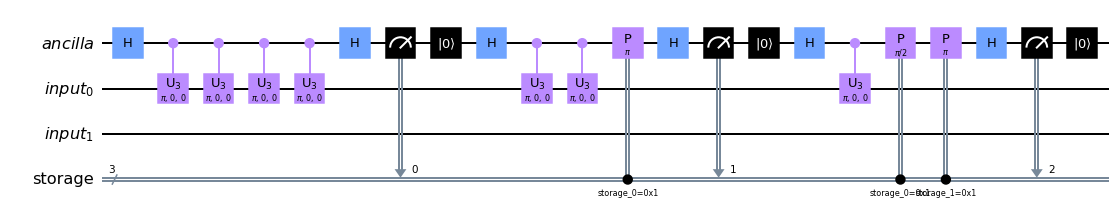

In [41]:
def QCL_QPE(A, depth):                             
    ancilla = QuantumRegister(1, name='ancilla')      
    inp = QuantumRegister(len(A), name='input')
    measurement = ClassicalRegister(depth, name='storage')

    qc = QuantumCircuit(ancilla, inp, measurement)
    
    
    for qubitNo in range(0, depth):       
        qc.h(ancilla[0])                        
        paramsA = mapAtoU3(A)
        power = depth-qubitNo-1
        for j in range(0, pow(2, power)):
            qc.cu3(paramsA[0].real, paramsA[1].real, paramsA[2].real, ancilla[0], inp[0])

        for i in range(0, qubitNo): 
            k = qubitNo - i
            qc.p(lambdaFromK(k), ancilla[0]).c_if(measurement[i], 1)
            
        qc.h(ancilla[0])                    
        qc.measure(ancilla[0], measurement[qubitNo]) 
        qc.reset(ancilla[0])                         
    return qc

A = [[0, -1], [1, 0]] 
qc = QCL_QPE(A, 3)
qc.draw('mpl')

\begin{align}\begin{aligned}\newcommand{\th}{\frac{\theta}{2}}\\U3\begin{split}(\theta, \phi, \lambda) =
    \begin{pmatrix}
        \cos(\th)          & -e^{i\lambda}\sin(\th) \\
        e^{i\phi}\sin(\th) & e^{i(\phi+\lambda)}\cos(\th)
    \end{pmatrix}\end{split}\end{aligned}\end{align}

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer

backend = BasicAer.get_backend('qasm_simulator')             ## Why does statevector and qsam gives different counts+
job_sim = backend.run(transpile(qc, backend), shots = 1024)  # despite 1024 shots, statevector gives only 1 count
result_sim = job_sim.result()                                # https://qiskit.org/documentation/stable/0.24/tutorials/simulators/1_aer_provider.html

In [43]:
counts = result_sim.get_counts(qc)
print("\nTotal",counts)      


Total {'110': 509, '010': 515}


In [ ]:
Algorithm 1: Optimize the selection of γ using n-bit
estimations of eigenvalues
Guess an overapproximation α of λmax
γ := 1/α // Initialize scaling parameter
x := 0
// At each step, γ ∗ λmax ≤ 1
while x 6= 2n − 1 do
p := n-bit output distribution of QCL-QPE using
unitary e
iA2πγ and input state |bi
x := max{j ∈ {0, ..., 2
n − 1}| pj > 0, pj ∈ p}
// x is an n-bit estimation of
// 2
n ∗ γ ∗ λmax
if x = 0 then
γ := γ ∗ 2
n
else
γ := γ ∗ (2n−1)/x
end
end
Result: γ = λ˜−1
max, with λ˜
max n-bit estimation of λmax

In [ ]:
Algorithm 2: Verify if α is a n-bit overestimation of
λmax
Assumption: at each step, there is at least one eigenvalue of γA not
in S
j∈Z

j − 2−(n+1), j + 2−(n+1)
// Initialize scaling parameter
Γ := 1/2
n+1α
p := n-bit output distribution of QCL-QPE using
unitary e
iA2πΓ and input state |bi
if p0 6= 1 then
Return α is not valid
// Otherwise all eigenvalues
// estimations would have been 0
else
Return α is valid
end
Result: Return if α is an overestimation of λmax

In [ ]:
θi = 2 arcsin(C/λ˜i)